## Radio interferometría y síntesis de imágenes en astronomía - Laboratorio 1
### Vicente Mieres

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta, timezone
import juliandate as jd

## Funciones y utilidades

### Funciones principales

In [22]:
def ecef_to_enu(ecef, array_center, phi=-33.45, lamb=-70.66, rad=True, is_array=True):
  '''
  ecef in meters (xyz)
  array_center: central antenna coords
  phi: latitud
  lamb (lambda): longitude
  rad: True if phi and lambd need to be radians
  '''
  if rad:
      phi, lamb = np.deg2rad(phi), np.deg2rad(lamb)

  cphi, clam = np.cos(phi), np.cos(lamb)
  sphi, slam = np.sin(phi), np.sin(lamb)


  R = np.array([[-slam,        clam,       0],
                [-clam*sphi,   -slam*sphi, cphi],
                [clam*cphi,    slam*cphi,  sphi]])

  dxyz = np.array(ecef) - np.array(array_center)
  
  enu = R @ dxyz.T if is_array else R @ dxyz

  return enu


def enu_to_altaz(enu, rad=True, is_array=True):
  '''
  Transform the enu vector to altitude and azimut
  '''

  if is_array:
    E, N, U = enu[0], enu[1], enu[2]
  else:
    E, N, U = float(enu[0]), float(enu[1]), float(enu[2])

  r = np.hypot(E, N)           
  El = np.arctan2(U, r)
  A = np.arctan2(E, N)
  
  if rad:
      return A % (2*np.pi), El  
  else:
      A_deg = np.degrees(A) % 360.0
      El_deg = np.degrees(El)
      return A_deg, El_deg

def local_sidereal_time(longitude=-70.76, utc=None, single=True):
  """
  Calculates the local sidereal time in Radians.
  """
  if utc is None:
    now = datetime.now(timezone.utc)
  else:
    now = utc

  jd_now = jd.from_gregorian(now.year, now.month, now.day, now.hour, now.minute, now.second)
  T = (jd_now - 2451545.0) / 36525
  theta = 280.46061837 + 360.98564736629 * (jd_now - 2451545) + (0.000387933 * T * T) - (T * T * T / 38710000.0)
  deg = theta % 360 + longitude

  h,m,s = degree_to_time(deg)
  rad = np.deg2rad(deg)
  
  if single: 
    return rad 
  else: 
    return deg, rad, h, m, s

def degree_to_time(theta, is_rad=False):
  """
  Converts degrees to hours, minutes and seconds.
  """
  if is_rad:
    theta = np.rad2deg(theta)

  h = int(theta/ 15)
  m = (int)(((theta / 15) - h) * 60)
  s = ((((theta / 15) - h) * 60) - m) * 60
  return h, m, s

def Rz(theta):
  c, s = np.cos(theta), np.sin(theta)
  return np.array([[ c, -s, 0],
                   [ s, c, 0],
                   [ 0, 0, 1]])

def Ry(theta):
  c, s = np.cos(theta), np.sin(theta)
  return np.array([[ c, 0, s],
  [ 0, 1, 0],
  [-s, 0, c]])

def hor_to_eq(alt, az, lst, phi=-33.44, is_array=True):
  """
  Transforma coordenadas horizontales (Alt, Az) -> ecuatoriales (α, δ).
  Parámetros
  ----------
  alt : Altitud (elevación) en radianes.
  az : Azimut en radianes (medido desde el Norte hacia el Este).
  lat : Latitud del observador en radianes.
  lst : Tiempo sideral local en radianes.
  Retorna
  -------
  alpha : Ascensión recta (α) en radianes, en el rango [0, 2π).
  delta : Declinación (δ) en radianes.
  """
  # --- Vector en sistema horizontal ENU ---
  # ENU = (East, North, Up)
  E = np.sin(az) * np.cos(alt)
  N = np.cos(az) * np.cos(alt)
  U = np.sin(alt)
  
  R = Rz(lst) @ Ry(phi)

  if is_array:
    v_hor = np.stack([E, N, U], axis=-1)
    r_eq = v_hor @ R.T 
    x, y, z = r_eq[:,0], r_eq[:,1], r_eq[:,2]
  else:
    v_hor = np.array([E, N, U])   
    r_eq = R @ v_hor
    x, y, z = r_eq

  # --- Extraer (α, δ) ---  
  delta = np.arcsin(np.clip(z, -1.0, 1.0))     # declinación
  alpha = np.mod(np.arctan2(y, x), 2*np.pi)    # ascensión recta (0..2π)

  return alpha, delta, r_eq

def eq_to_uvw(H, delta, hor_coords, is_array=True):
  '''
  Return the uvw coords of an antenna o antenna array 
  '''
  ch, cd = np.cos(H), np.cos(delta)
  sh, sd = np.sin(H), np.sin(delta)

  R = np.array([[sh,        ch,      0],
                [-sd*ch,   sd*sh,   cd],
                [cd*ch,   -cd*ch,   sd]])
  
  uvw = hor_coords @ R.T if is_array else R @ hor_coords

  return uvw




### Funciones secundarias

In [23]:
# utilidades 

def read_cfg_to_enu(filename, array_center=None ,phi=-33.44, lamb=-70.76, rad=True):
  '''
  Read file and return antenna config on ENU coords
  '''
  with open(filename, "r") as f:
    lines = f.readlines()

  coordsys = None 
  for line in lines:
        if line.startswith("# coordsys"):
            coordsys = line.split("=")[1].strip()
            break
  
  antennas = []
  for line in lines:
      if line.startswith("#") or not line.strip():
          continue
      parts = line.split()
      x, y, z = map(float, parts[:3])
      antennas.append([x, y, z])
  antennas = np.array(antennas)

  if coordsys == "LOC (local tangent plane)": return antennas.T
  elif coordsys == "XYZ":
     array_center = array_center if array_center is not None else antennas.mean(axis=0)
     enu_antennas = ecef_to_enu(antennas, array_center, phi, lamb, rad)
     return enu_antennas
  else:
    raise ValueError(f"coordsys desconocido: {coordsys}")

def plot_antennas(enu_coords, labels=True, title="Configuración de Antenas"):
    """
    Muestra la configuración de antenas a partir de sus coordenadas ENU.

    Parámetros
    ----------
    enu_coords : ndarray (N,3)
        Arreglo con las coordenadas [E, N, U] de cada antena.
    labels : bool
        Si True, muestra el índice de cada antena en el gráfico.
    title : str
        Título del gráfico.
    """
    enu_coords = np.array(enu_coords)
    E, N, U = enu_coords[:,0], enu_coords[:,1], enu_coords[:,2]

    fig = plt.figure(figsize=(12,6))

    # --- Subplot 1: Vista en planta (E vs N) ---
    ax1 = fig.add_subplot(1,2,1)
    ax1.scatter(E, N, c='black', marker='o')
    if labels:
        for i, (e, n) in enumerate(zip(E, N)):
            ax1.text(e, n, str(i), fontsize=9, ha='right')
    ax1.set_xlabel("East [m]")
    ax1.set_ylabel("North [m]")
    ax1.set_title("Vista en planta (E-N)")
    ax1.grid(True)
    ax1.axis('equal')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


In [24]:
center = [5111214.575406, 2001317.289008, -3237315.843578]

enu = read_cfg_to_enu("../antenna_arrays/alma.cycle10.10.cfg", array_center=center)

alt, az = enu_to_altaz(enu)

lst = local_sidereal_time(single=True)

d, a, l= hor_to_eq(alt,az, lst)

l

array([[-0.62713328, -0.64425858,  0.43776103],
       [-0.57602519,  0.8123972 , -0.0905857 ],
       [ 0.94065129, -0.21855087, -0.25963563],
       [-0.94697764,  0.10620008,  0.30324064],
       [ 0.01611957,  0.94757155, -0.31913684],
       [-0.1690972 , -0.91047996,  0.37740214],
       [-0.74164322,  0.670229  ,  0.02753964],
       [ 0.8647093 ,  0.28834517, -0.41126014],
       [-0.2070312 ,  0.94181892, -0.26479277],
       [ 0.46828338, -0.8719854 ,  0.14266092],
       [-0.93390679,  0.25907849,  0.24636648],
       [-0.77268808,  0.63318692,  0.04502734],
       [-0.02719081,  0.95268975, -0.30272578],
       [-0.92923491, -0.09857903,  0.3560964 ],
       [ 0.91207446,  0.13754964, -0.38626451],
       [ 0.85511013,  0.30738216, -0.41749595],
       [ 0.8907362 ,  0.2169864 , -0.39938192],
       [ 0.91243307,  0.14213807, -0.38374817],
       [ 0.91088371,  0.14907256, -0.38479636],
       [ 0.91206684,  0.1409944 , -0.38503851],
       [ 0.9271176 ,  0.07411717, -0.367

In [25]:
import numpy as np

def simulate_uv_coverage(hor_coords, delta0_deg, H_hours=(-6, 6), step_min=10):
    """
    Genera coordenadas (u, v, w) para un rango de horas angulares sin bucle explícito.
    Usa broadcasting de NumPy.
    """

    # Convertir a radianes
    delta0 = np.deg2rad(delta0_deg)
    H_start, H_end = np.deg2rad(np.array(H_hours) * 15)  # 15° por hora
    H_rad = np.arange(H_start, H_end + 1e-9, np.deg2rad(step_min * 0.25))  # 0.25°/min = 15°/h

    # Precalcular senos y cosenos
    sh, ch = np.sin(H_rad), np.cos(H_rad)
    sd, cd = np.sin(delta0), np.cos(delta0)

    # Matriz de rotación R para cada H (shape: (M, 3, 3))
    R = np.stack([
        np.stack([sh,       ch,       np.zeros_like(sh)], axis=-1),
        np.stack([-sd*ch,   sd*sh,    np.full_like(ch, cd)], axis=-1),
        np.stack([cd*ch,   -cd*sh,    np.full_like(ch, sd)], axis=-1)
    ], axis=1)  # → shape (3, 3, M)
    R = np.moveaxis(R, -1, 0)  # → shape (M, 3, 3)

    # Broadcasting: (M,3,3) @ (3,N) → (M,3,N)
    uvw = (R @ hor_coords.T).transpose(2,1,0)  # → (N,3,M)

    return uvw, H_rad


def compute_baselines(ant_pos):
    """
    ant_pos: np.ndarray (N,3) posiciones de antenas (ENu/E,N,U)
    retorna: baselines (B,3) con B = N*(N-1)/2
    """
    N = len(ant_pos)
    i_idx, j_idx = np.triu_indices(N, k=1)   # indices i<j
    baselines = ant_pos[j_idx] - ant_pos[i_idx]
    return baselines, i_idx, j_idx


def simulate_uv_from_baselines(ant_pos, delta0_deg, H_hours=(-6,6), step_min=10):
    """
    Devuelve uvw para todos los baselines y todos los H (sin bucle, con broadcasting).
    ant_pos: (N,3) posiciones de antenas (ENu)
    delta0_deg: declinación de la fuente en grados
    """
    baselines, i_idx, j_idx = compute_baselines(ant_pos)  # (B,3)
    # Reusar la version vectorizada para generar uvw:
    uvw, H_rad = simulate_uv_coverage(baselines, delta0_deg, H_hours=H_hours, step_min=step_min)
    # uvw tiene shape (B, 3, M)
    return uvw, H_rad, i_idx, j_idx


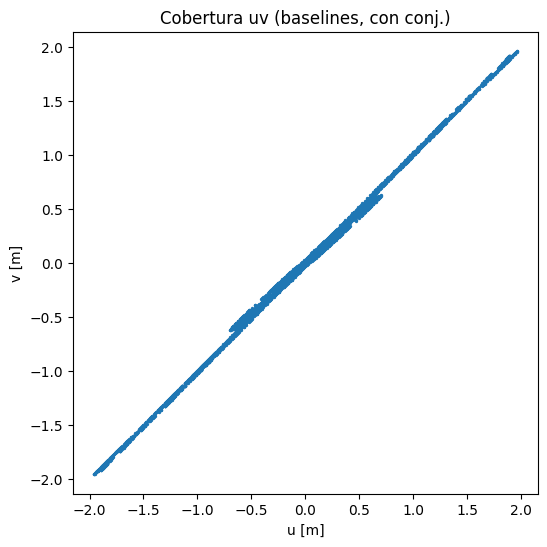

In [26]:
uvw, H_rad, i_idx, j_idx = simulate_uv_from_baselines(l, delta0_deg=-30,
                                                      H_hours=(-6,6), step_min=10)

u = uvw[:, 0, :].ravel()
v = uvw[:, 1, :].ravel()

# agregar los puntos conjugados (-u,-v) si quieres ver la simetría Hermitiana
u_all = np.hstack([u, -u])
v_all = np.hstack([v, -v])

plt.figure(figsize=(6,6))
plt.scatter(u_all, v_all, s=2)
plt.axis('equal')
plt.xlabel('u [m]')
plt.ylabel('v [m]')
plt.title('Cobertura uv (baselines, con conj.)')
plt.show()
